<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_RSCCMM_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv

In [ ]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values[:, 1:]
TEST = data_test.values

print(X.shape)
print(TEST.shape)

(943, 1682)
(10000, 3)


In [ ]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


In [ ]:
#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u

In [ ]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_AVE(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rough_u = RSCCMM(X, C, delta)
    print(f"各クラスターの要素数: {np.sum(rough_u, axis=1)}")

    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64))
    print(f"オーバーラップしている要素の数: {n_overlaps}")
    print(f"オーバーラップしていないクラスターの数: {X.shape[0] - n_overlaps}")

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score)
    auc_sum += auc

  return auc_sum/roop

print(RSCCMM_CF_AUC_AVE(1, TEST, X_movie, 5, -7.44))

各クラスターの要素数: [942. 917. 914. 918. 919.]
オーバーラップしている要素の数: 921.0
オーバーラップしていないクラスターの数: 22.0
0.7029950795234843


[-7.428 -7.429 -7.43  -7.431 -7.432 -7.433 -7.434 -7.435 -7.436 -7.437
 -7.438 -7.439 -7.44 ]
各クラスターの要素数: [498. 356. 454. 338. 341.]
オーバーラップしている要素の数: 386.0
オーバーラップしていないクラスターの数: 557.0
cluster5, delta=-7.428, auc=0.7053324201870771
各クラスターの要素数: [529. 540. 533. 789. 660.]
オーバーラップしている要素の数: 613.0
オーバーラップしていないクラスターの数: 330.0
cluster5, delta=-7.429, auc=0.7106559053103375
各クラスターの要素数: [840. 612. 654. 638. 754.]
オーバーラップしている要素の数: 705.0
オーバーラップしていないクラスターの数: 238.0
cluster5, delta=-7.430000000000001, auc=0.7080510388003123
各クラスターの要素数: [733. 911. 709. 735. 699.]
オーバーラップしている要素の数: 743.0
オーバーラップしていないクラスターの数: 200.0
cluster5, delta=-7.431000000000001, auc=0.7019438741214612
各クラスターの要素数: [831. 910. 766. 762. 761.]
オーバーラップしている要素の数: 817.0
オーバーラップしていないクラスターの数: 126.0
cluster5, delta=-7.432000000000001, auc=0.7049231392294584
各クラスターの要素数: [806. 800. 924. 815. 846.]
オーバーラップしている要素の数: 850.0
オーバーラップしていないクラスターの数: 93.0
cluster5, delta=-7.433000000000002, auc=0.7019797681504714
各クラスターの要素数: [837. 842. 940. 836. 844.]
オーバー

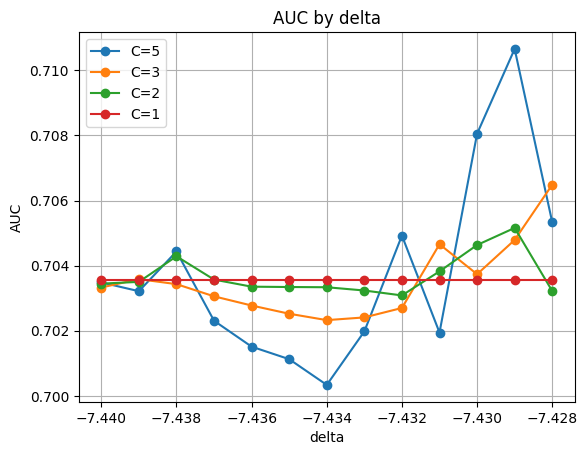

In [ ]:
#deltaのリスト
name = "NEEDS_RSCCMM_delta"
delta_list = np.arange(-7.428, -7.44, -0.001)
print(delta_list)

#Cのリスト
C = [5, 3, 2, 1]
output = [delta_list.tolist()]
for c in C:
  #aucのリスト
  auc_list = []

  for delta in delta_list:
    auc = RSCCMM_CF_AUC_AVE(1, TEST, X_movie, c, delta)
    print(f"cluster{c}, delta={delta}, auc={auc}")
    auc_list.append(auc)
  plt.plot(delta_list, auc_list, marker = 'o', label=f"C={c}")
  output.append(auc_list)




# plt.hlines(0.70355, delta_list[0], delta_list[len(delta_list)-1], color="k", label="C=1")
plt.legend()
plt.title('AUC by delta')
plt.xlabel('delta')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)